In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!p7zip -d '/content/gdrive/MyDrive/cats_dogs_dataset.7z'

/usr/bin/p7zip: cannot read /content/gdrive/MyDrive/cats_dogs_dataset.7z


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

In [4]:
def preprocessing_dataset(folder):
    list_data = os.listdir(folder)
    list_data.sort()
    
    images = []
    vec = []
    for name in list_data:
        if name.endswith('.jpg'):
            img = cv2.resize(cv2.imread('{}/{}'.format(folder, name)), dsize=(224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        else:
            with open('{}/{}'.format(folder, name), 'r') as f:
                s = f.read()
                vec.append(s)
            
    vectors = []
    for i in range(len(vec)):
        vectors.append(vec[i].split(' '))
    

    labels = []
    for i in range(0, len(vectors)):
        labels.append(vectors[i][0])
    
    images = np.array(images)
    images = backend.cast_to_floatx(images)
    images /= 255.
    labels = np.array(labels).astype('int')
    
    
    X_train, X_test, y_train, y_test = \
            train_test_split(images, labels, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=3)
    y_test = to_categorical(y_test, num_classes=3)
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = preprocessing_dataset('cats_dogs_dataset')
print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((2708, 224, 224, 3), (2708, 3)) ((677, 224, 224, 3), (677, 3))


In [6]:
def createModel():
    model = Sequential([
        Conv2D(filters = 32, kernel_size=(5,5), strides=2, padding='valid',
               activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(pool_size=(3,3), strides = 2),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2,2), strides=2),
        Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2,2), strides=2),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1(l1=0.00001), bias_regularizer= regularizers.l2(l2=0.0001)),
        Dropout(0.25),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l1(l1=0.00001), bias_regularizer= regularizers.l2(l2=0.0001)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l1(l1=0.00001), bias_regularizer= regularizers.l2(l2=0.0001)),
        Dropout(0.20),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l1(l1=0.0001), bias_regularizer= regularizers.l2(l2=0.0001)),
        Dense(3, activation='softmax')
    ])

    return model
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 256)       2

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])

stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40,restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002,  patience = 30, min_lr = 1e-7, verbose = 1)

In [8]:
his = model.fit(X_train, y_train,
                validation_data = (X_test, y_test),
                epochs = 100, batch_size=128,
                callbacks=[reduce_lr, stop], verbose=2)

Epoch 1/100
22/22 - 8s - loss: 0.9460 - accuracy: 0.5000 - val_loss: 0.7506 - val_accuracy: 0.6588
Epoch 2/100
22/22 - 2s - loss: 0.6974 - accuracy: 0.7024 - val_loss: 0.6865 - val_accuracy: 0.6588
Epoch 3/100
22/22 - 2s - loss: 0.6364 - accuracy: 0.7024 - val_loss: 0.6281 - val_accuracy: 0.6588
Epoch 4/100
22/22 - 2s - loss: 0.5859 - accuracy: 0.7024 - val_loss: 0.6076 - val_accuracy: 0.6588
Epoch 5/100
22/22 - 2s - loss: 0.5629 - accuracy: 0.7024 - val_loss: 0.5679 - val_accuracy: 0.6588
Epoch 6/100
22/22 - 2s - loss: 0.5319 - accuracy: 0.7024 - val_loss: 0.5427 - val_accuracy: 0.6588
Epoch 7/100
22/22 - 2s - loss: 0.5204 - accuracy: 0.7024 - val_loss: 0.5250 - val_accuracy: 0.6588
Epoch 8/100
22/22 - 2s - loss: 0.5138 - accuracy: 0.7020 - val_loss: 0.5262 - val_accuracy: 0.6617
Epoch 9/100
22/22 - 2s - loss: 0.4937 - accuracy: 0.7116 - val_loss: 0.4997 - val_accuracy: 0.6928
Epoch 10/100
22/22 - 2s - loss: 0.4798 - accuracy: 0.7179 - val_loss: 0.4997 - val_accuracy: 0.6957
Epoch 11/

Text(0.5, 1.0, 'Loss Curves')

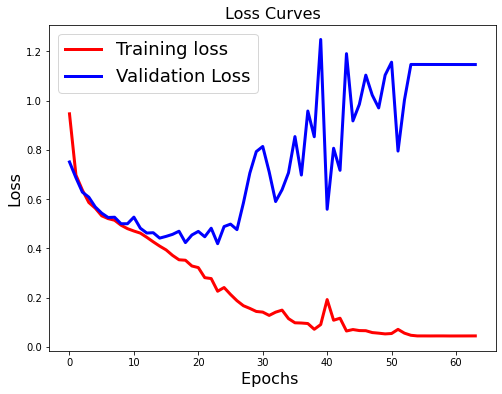

In [9]:
plt.figure(figsize=[8,6])
plt.plot(his.history['loss'],'r',linewidth=3.0)
plt.plot(his.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


Text(0.5, 1.0, 'Accuracy Curves')

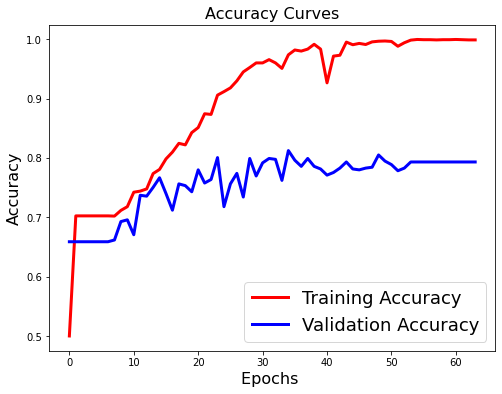

In [10]:
plt.figure(figsize=[8,6])
plt.plot(his.history['accuracy'],'r',linewidth=3.0)
plt.plot(his.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model2 = createModel()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

his2 = model2.fit(datagen.flow(X_train, y_train, batch_size=256),
                      steps_per_epoch=int(np.ceil(X_train.shape[0] / float(256))),
                      epochs=50,
                      validation_data=(X_test, y_test), callbacks=[reduce_lr, stop],
                      workers=4)
model2.evaluate(X_test, y_test)


Epoch 1/50
11/11 [==============================] - 24s 1s/step - loss: 0.9998 - accuracy: 0.6012 - val_loss: 0.7858 - val_accuracy: 0.6588
Epoch 2/50
11/11 [==============================] - 20s 1s/step - loss: 0.7744 - accuracy: 0.6987 - val_loss: 0.7494 - val_accuracy: 0.6588
Epoch 3/50
11/11 [==============================] - 26s 1s/step - loss: 0.7205 - accuracy: 0.7024 - val_loss: 0.7196 - val_accuracy: 0.6588
Epoch 4/50
11/11 [==============================] - 27s 1s/step - loss: 0.6830 - accuracy: 0.7024 - val_loss: 0.6872 - val_accuracy: 0.6588
Epoch 5/50
11/11 [==============================] - 20s 1s/step - loss: 0.6543 - accuracy: 0.7024 - val_loss: 0.6577 - val_accuracy: 0.6588
Epoch 6/50
11/11 [==============================] - 26s 1s/step - loss: 0.6266 - accuracy: 0.7024 - val_loss: 0.6401 - val_accuracy: 0.6588
Epoch 7/50
11/11 [==============================] - 27s 1s/step - loss: 0.6124 - accuracy: 0.7024 - val_loss: 0.6153 - val_accuracy: 0.6588
Epoch 8/50
11/11 [==

[0.3386783301830292, 0.8079763650894165]

Text(0.5, 1.0, 'Accuracy Curves')

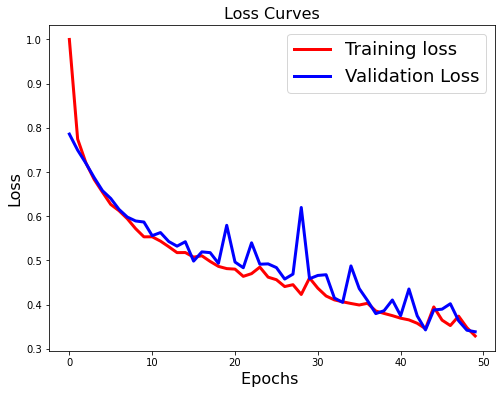

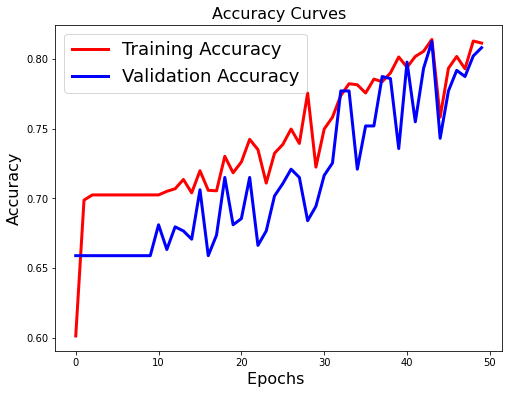

In [12]:
plt.figure(figsize=[8,6])
plt.plot(his2.history['loss'],'r',linewidth=3.0)
plt.plot(his2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(his2.history['accuracy'],'r',linewidth=3.0)
plt.plot(his2.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)